In [1]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 22.0 MB/s eta 0:00:00
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.3.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 18.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 37.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.5/38.5 MB 27.0 MB/s eta 0:00:0000:0100:01
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 27.3 MB/s eta 0:00:0000:0100:01
Using cached threadpoolctl-3.3.0-py3-none-any.whl (17 kB)
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=904c00ff3a13e4887bb106c77ebd19b

In [2]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load Data

In [4]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

100%|██████████| 170498071/170498071 [00:07<00:00, 22987769.91it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
data_variance = np.var(training_data.data / 255.0)

## Vector Quantizer Layer

In [6]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

## Encoder & Decoder Architecture

In [7]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [8]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [9]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=out_channels,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

## Train

In [10]:
batch_size = 256
num_training_updates = 5000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

learning_rate = 1e-3

In [11]:
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

In [12]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [13]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost):
        super(Model, self).__init__()

        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)

        self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim, 3,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [14]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost).to(device)

In [15]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [16]:
model.train()
train_res_recon_error = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())

    if (i+1) % 500 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print()

500 iterations
recon_error: 0.368

1000 iterations
recon_error: 0.240

1500 iterations
recon_error: 0.179

2000 iterations
recon_error: 0.159

2500 iterations
recon_error: 0.148

3000 iterations
recon_error: 0.132

3500 iterations
recon_error: 0.123

4000 iterations
recon_error: 0.112

4500 iterations
recon_error: 0.100

5000 iterations
recon_error: 0.094



## Plot Loss

In [17]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)

Text(0.5, 0, 'iteration')

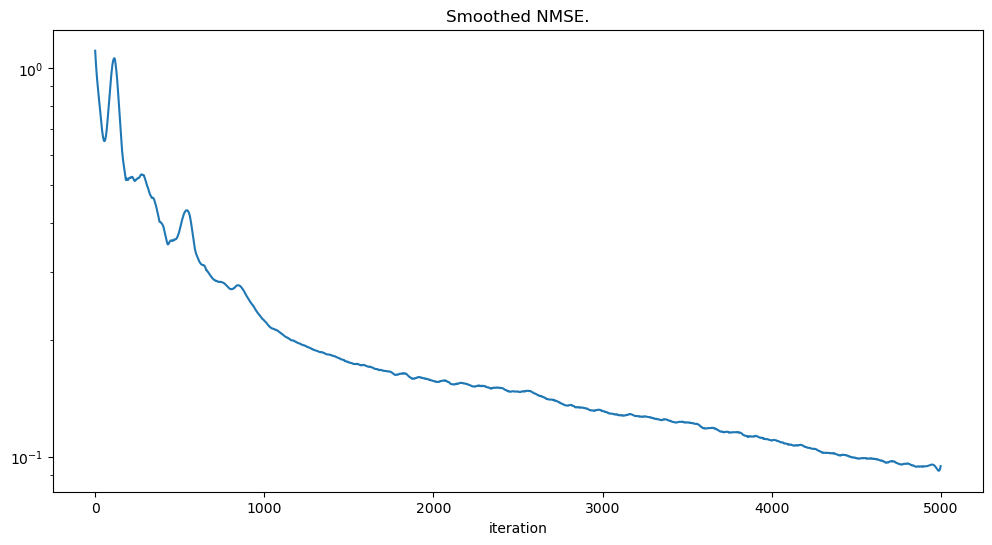

In [18]:
plt.figure(figsize=(12,6))
plt.plot(train_res_recon_error_smooth)
plt.yscale('log')
plt.title('Smoothed NMSE.')
plt.xlabel('iteration')

## View Reconstructions

In [19]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [20]:
torch.max(model._encoder(valid_originals))

tensor(33.2481, device='cuda:0', grad_fn=<MaxBackward1>)

In [21]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [22]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


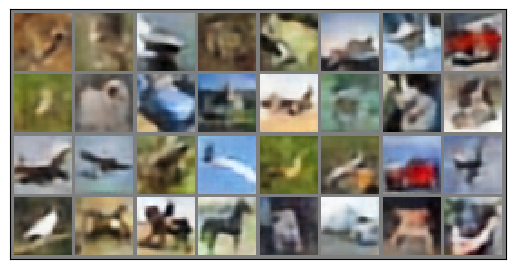

In [23]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

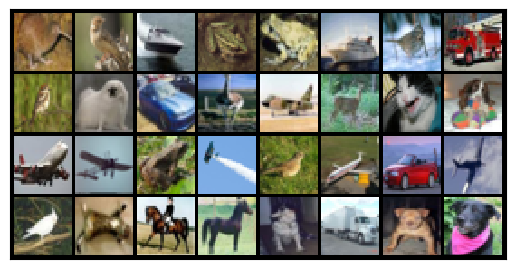

In [24]:
show(make_grid(valid_originals.cpu()+0.5))

## View Embedding

In [25]:
import umap.umap_ as umap

proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

/home/dalen/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dalen/miniconda3/envs/py39/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


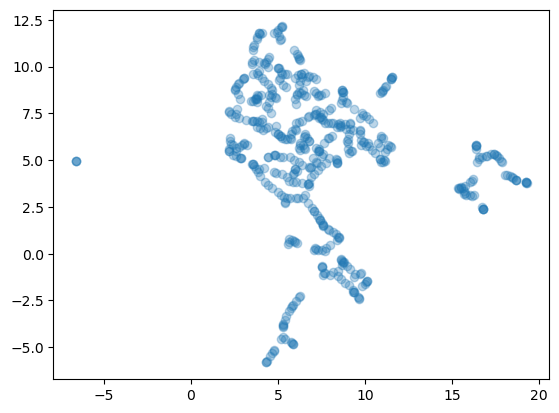

In [26]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)